Vamos a entrenar un discriminador de imagenes utiles o no utiles

In [1]:
pip install huggingface_hub -U

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 32.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.4/166.4 kB 35.3 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2022.5.0
    Uninstalling fsspec-2022.5.0:
      Successfully uninstalled fsspec-2022.5.0
  Attempting uninstall: huggingface_hub
    Found existing installation: huggingface-hub 0.8.1
    Uninstalling huggingface-hub-0.8.1:
      Successfully uninstalled huggingface-hub-0.8.1
Note: you may need to restart the kernel to use updated packages.


In [2]:
from fastai.vision.all import *
import os
import timm
from fastai.vision.widgets import *
import huggingface_hub
import fastai

In [4]:

timm.list_models()


['bat_resnext26ts',
 'beit_base_patch16_224',
 'beit_base_patch16_384',
 'beit_large_patch16_224',
 'beit_large_patch16_384',
 'beit_large_patch16_512',
 'beitv2_base_patch16_224',
 'beitv2_large_patch16_224',
 'botnet26t_256',
 'botnet50ts_256',
 'caformer_b36',
 'caformer_m36',
 'caformer_s18',
 'caformer_s36',
 'cait_m36_384',
 'cait_m48_448',
 'cait_s24_224',
 'cait_s24_384',
 'cait_s36_384',
 'cait_xs24_384',
 'cait_xxs24_224',
 'cait_xxs24_384',
 'cait_xxs36_224',
 'cait_xxs36_384',
 'coat_lite_medium',
 'coat_lite_medium_384',
 'coat_lite_mini',
 'coat_lite_small',
 'coat_lite_tiny',
 'coat_mini',
 'coat_small',
 'coat_tiny',
 'coatnet_0_224',
 'coatnet_0_rw_224',
 'coatnet_1_224',
 'coatnet_1_rw_224',
 'coatnet_2_224',
 'coatnet_2_rw_224',
 'coatnet_3_224',
 'coatnet_3_rw_224',
 'coatnet_4_224',
 'coatnet_5_224',
 'coatnet_bn_0_rw_224',
 'coatnet_nano_cc_224',
 'coatnet_nano_rw_224',
 'coatnet_pico_rw_224',
 'coatnet_rmlp_0_rw_224',
 'coatnet_rmlp_1_rw2_224',
 'coatnet_rmlp_1_r

In [3]:
#definimos el camino a los archivos
train_path = "dataset_resized"


(256, 256)


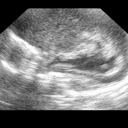

In [4]:

archivos = get_image_files(train_path)
img = PILImage.create(archivos[0])
print(img.size)
img.to_thumb(128)

Veamos de que tamaños son las imagenes de nuestro dataset, pues en caso de ser distintas cambiaremos el tamaño de todas a uno estandar

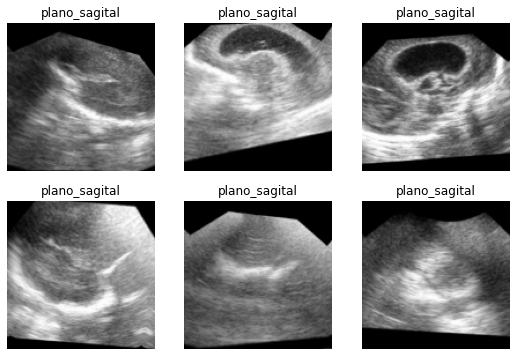

In [5]:
dls = ImageDataLoaders.from_folder(train_path, valid_pct=0.2, seed=42,
    item_tfms=Resize(200, method='squish'),
    batch_tfms=aug_transforms(size=128, min_scale=0.75))

dls.show_batch(max_n=6)

In [6]:

learn = vision_learner(dls, resnet50, metrics=[accuracy, error_rate]).to_fp16()


/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

SuggestedLRs(valley=0.0010000000474974513, slide=0.013182567432522774)

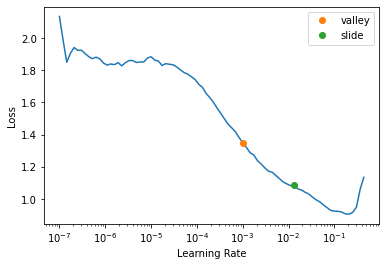

In [7]:
learn.lr_find(suggest_funcs=(valley, slide))

Al usar lr_find para encontrar el learning rate apropiado nos sugiere 0.001 nosotros vamos a ir más al limite y usar un lr de 0.01.
#¿qué es el learning rate?

In [8]:
learn.fine_tune(3, 0.01)

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.312186,0.283857,0.921120,0.078880,00:37


epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.199048,0.136739,0.938184,0.061816,00:47
1,0.128633,0.074293,0.968770,0.031230,00:47
2,0.073771,0.059007,0.976175,0.023825,00:46


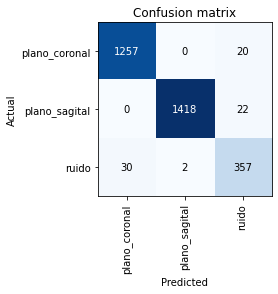

In [9]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

In [13]:
def train(arch, item, batch, epochs=5):
    dls = ImageDataLoaders.from_folder(train_path, seed=42, valid_pct=0.2, item_tfms=item, batch_tfms=batch)
    learn = vision_learner(dls, arch, metrics=[accuracy, error_rate],ps=0.5).to_fp16()
    learn.fine_tune(epochs, 0.001)
    return learn


Ahora probaremos otro modelo
buscamos su learning rate apropiado, parece ser que 0.00015

SuggestedLRs(valley=0.00015848931798245758, slide=0.00013182566908653826)

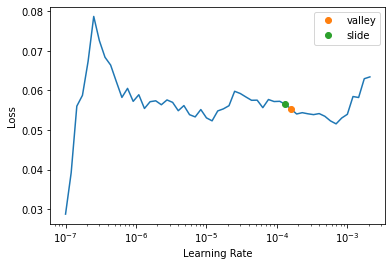

In [10]:

arch = "convnext_tiny.in12k_ft_in1k_384"
#learn = vision_learner(dls, arch, metrics= [accuracy,error_rate]).to_fp16()
learn.lr_find(suggest_funcs=(valley, slide))

In [12]:
learn = train(arch, item=Resize(200, method='squish'),
              batch=aug_transforms(size=128, min_scale=0.75))

model.safetensors:   0%|          | 0.00/114M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.500324,0.223238,0.910818,0.089182,01:13


epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.331952,0.187473,0.927238,0.072762,02:20
1,0.248625,0.145605,0.936252,0.063748,02:20
2,0.183328,0.159356,0.935930,0.064070,02:20
3,0.185839,0.139815,0.943979,0.056021,02:20
4,0.177129,0.141272,0.942692,0.057308,02:21


con este modelo convnext hemos conseguido bastante mejora pero al coste de aumentar el tiempo de entrenamiento
seguimos haciendo pruebas en el preprocesamiento

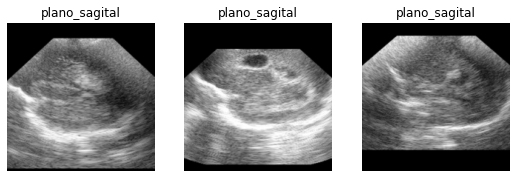

In [14]:
dls = ImageDataLoaders.from_folder(train_path, valid_pct=0.2, seed=42,
    item_tfms=Resize(200, method=ResizeMethod.Pad, pad_mode=PadMode.Zeros))
dls.show_batch(max_n=3)

In [15]:

learn = train(arch, item=Resize((400,400), method=ResizeMethod.Pad, pad_mode=PadMode.Zeros),
      batch=aug_transforms(size=(128,128), min_scale=0.75))

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.318247,0.195310,0.928525,0.071475,01:19


epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.180604,0.134441,0.946233,0.053767,02:25
1,0.142710,0.120984,0.950419,0.049581,02:25
2,0.105305,0.137223,0.948165,0.051835,02:25
3,0.092424,0.079337,0.966194,0.033806,02:25
4,0.072712,0.085603,0.964585,0.035415,02:25


vamos a hacer a continuacion un test time augmentation para asegurarnos que las transformacion para aumentar el dataset no estan afectando al ratio de error por eso haremos la media de varios intentos

In [16]:
valid = learn.dls.valid
preds,targs = learn.get_preds(dl=valid)

In [17]:
error_rate(preds, targs)

TensorBase(0.0354)

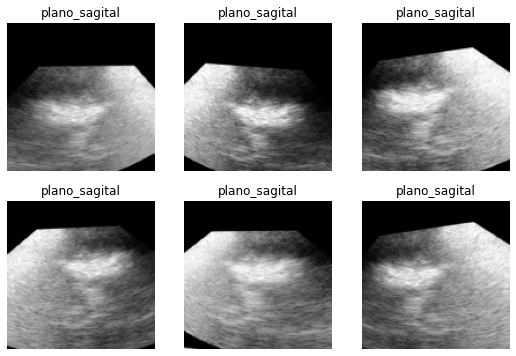

In [18]:
learn.dls.train.show_batch(max_n=6, unique=True)

In [19]:
tta_preds,_ = learn.tta(dl=valid)

In [20]:
error_rate(tta_preds, targs)

TensorBase(0.0219)

Vemos que vamos por el buen camino, la media no se aleja mucho del resultado que hemos obtenido.
Ahora podemos escalar esto, darle potencia y mas epocas.

In [ ]:
??aug_transforms

In [21]:

learn = train(arch, epochs=12,
              item=Resize((400, 400), method=ResizeMethod.Pad, pad_mode=PadMode.Zeros),
              batch=aug_transforms(size=(192,192), min_scale=0.75))

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.317558,0.168272,0.931423,0.068577,02:45


epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.208676,0.136817,0.946233,0.053767,06:10
1,0.169707,0.146370,0.945589,0.054411,06:10
2,0.114116,0.096037,0.966838,0.033162,06:10
3,0.113495,0.106129,0.960721,0.039279,06:10
4,0.093181,0.081040,0.971990,0.028010,06:10
5,0.068662,0.054824,0.979073,0.020927,06:11
6,0.060365,0.064480,0.973921,0.026079,06:10
7,0.057722,0.055841,0.974887,0.025113,06:10
8,0.047581,0.057059,0.979717,0.020283,06:11
9,0.040460,0.048047,0.981648,0.018352,06:10


In [24]:
tta_preds,targs = learn.tta(dl=learn.dls.valid)


In [25]:
error_rate(tta_preds, targs)

TensorBase(0.0167)

In [26]:
accuracy(tta_preds, targs)

TensorBase(0.9833)

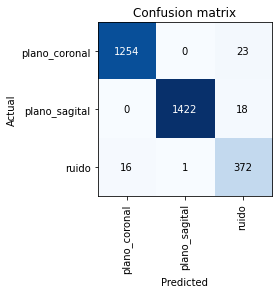

In [27]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

In [29]:
learn.export()

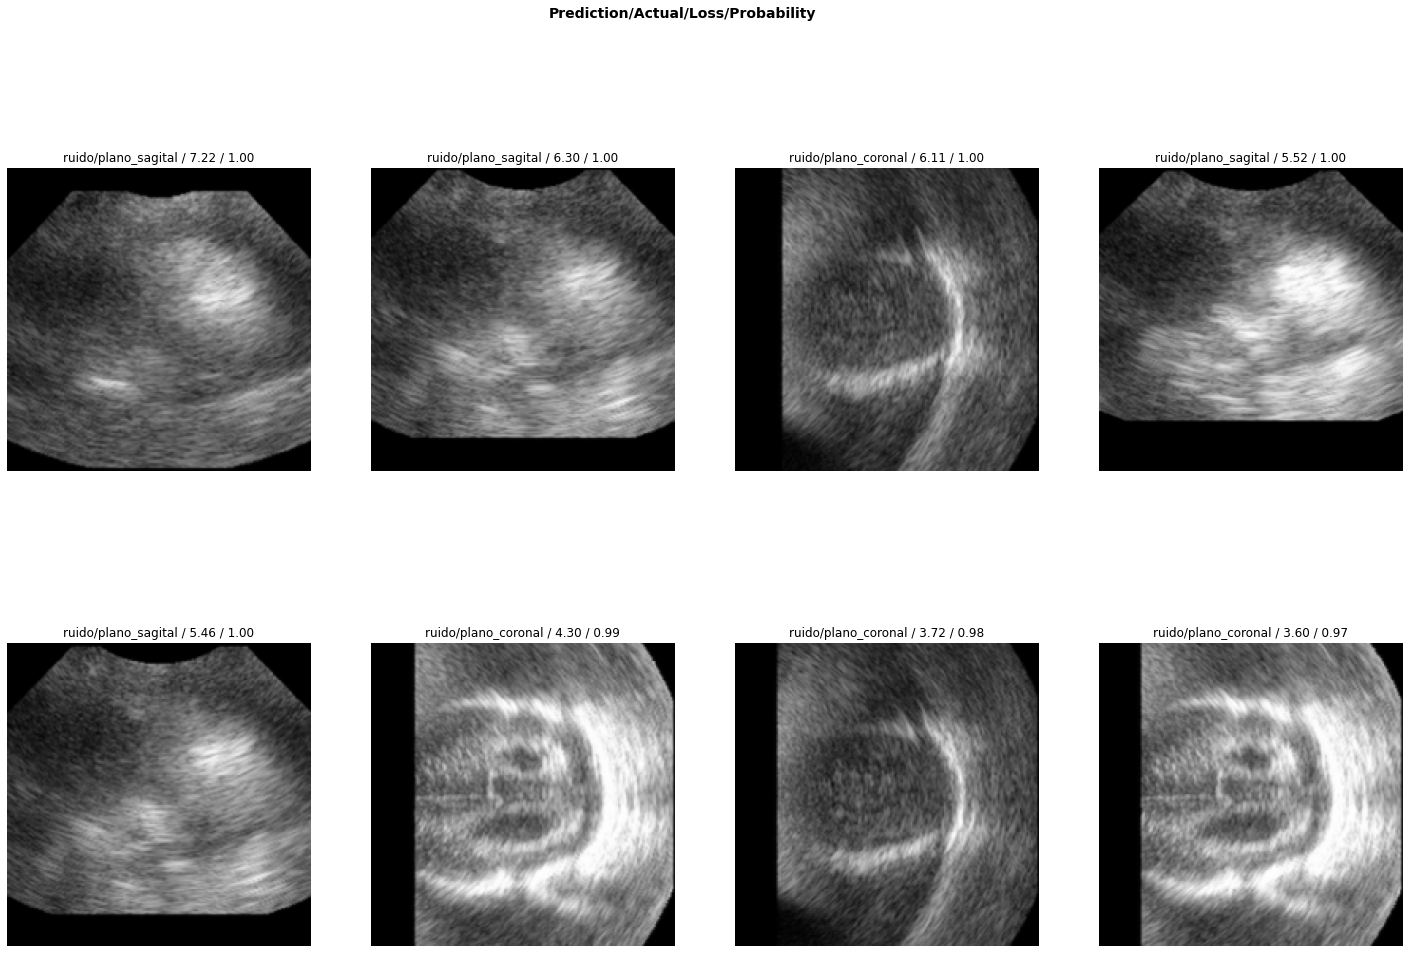

In [28]:
interp.plot_top_losses(8,figsize=(25, 16))

Observamos que donde falla mas es de plano_coronalNoutil a plano_sagital_NOutil y esto es normal porque ambos tienen regiones complatamente en negro, esos fallos no nos importan y podriamos decir que el modelo es mejor de lo que indica la metrica.

Ahora tocaria ponerlo a prueba con un conjunto de testeo nuevo con el que nunca se haya puesto a prueba y ver que tal lo hace. Me ha fallado pensar en esto desde el principio y ner preparado un conjunto de testeo con las etiquetas puestas porque ahora es mas complicado hacerlo

In [38]:
cleaner = ImageClassifierCleaner(learn)
cleaner

FileNotFoundError: Caught FileNotFoundError in DataLoader worker process 6.
Original Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/_utils/worker.py", line 302, in _worker_loop
    data = fetcher.fetch(index)
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/_utils/fetch.py", line 39, in fetch
    data = next(self.dataset_iter)
  File "/root/.local/lib/python3.9/site-packages/fastai/data/load.py", line 138, in create_batches
    yield from map(self.do_batch, self.chunkify(res))
  File "/root/.local/lib/python3.9/site-packages/fastcore/basics.py", line 230, in chunked
    res = list(itertools.islice(it, chunk_sz))
  File "/root/.local/lib/python3.9/site-packages/fastai/data/load.py", line 153, in do_item
    try: return self.after_item(self.create_item(s))
  File "/root/.local/lib/python3.9/site-packages/fastai/data/load.py", line 160, in create_item
    if self.indexed: return self.dataset[s or 0]
  File "/root/.local/lib/python3.9/site-packages/fastai/data/core.py", line 458, in __getitem__
    res = tuple([tl[it] for tl in self.tls])
  File "/root/.local/lib/python3.9/site-packages/fastai/data/core.py", line 458, in <listcomp>
    res = tuple([tl[it] for tl in self.tls])
  File "/root/.local/lib/python3.9/site-packages/fastai/data/core.py", line 417, in __getitem__
    return self._after_item(res) if is_indexer(idx) else res.map(self._after_item)
  File "/root/.local/lib/python3.9/site-packages/fastai/data/core.py", line 377, in _after_item
    def _after_item(self, o): return self.tfms(o)
  File "/root/.local/lib/python3.9/site-packages/fastcore/transform.py", line 208, in __call__
    def __call__(self, o): return compose_tfms(o, tfms=self.fs, split_idx=self.split_idx)
  File "/root/.local/lib/python3.9/site-packages/fastcore/transform.py", line 158, in compose_tfms
    x = f(x, **kwargs)
  File "/root/.local/lib/python3.9/site-packages/fastcore/transform.py", line 81, in __call__
    def __call__(self, x, **kwargs): return self._call('encodes', x, **kwargs)
  File "/root/.local/lib/python3.9/site-packages/fastcore/transform.py", line 91, in _call
    return self._do_call(getattr(self, fn), x, **kwargs)
  File "/root/.local/lib/python3.9/site-packages/fastcore/transform.py", line 97, in _do_call
    return retain_type(f(x, **kwargs), x, ret)
  File "/root/.local/lib/python3.9/site-packages/fastcore/dispatch.py", line 120, in __call__
    return f(*args, **kwargs)
  File "/root/.local/lib/python3.9/site-packages/fastai/vision/core.py", line 125, in create
    return cls(load_image(fn, **merge(cls._open_args, kwargs)))
  File "/root/.local/lib/python3.9/site-packages/fastai/vision/core.py", line 98, in load_image
    im = Image.open(fn)
  File "/usr/local/lib/python3.9/dist-packages/PIL/Image.py", line 3092, in open
    fp = builtins.open(filename, "rb")
FileNotFoundError: [Errno 2] No such file or directory: '/notebooks/dataset_resized/plano_coronal/1_2013_11_08_slice_25_22.png'


In [27]:
from pathlib import Path

path = Path(train_path)

In [28]:
for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)

Vamos a ver si mejoran nuestros resultados con este nuevo dataset que hemos limpiado y mejorado su etiquetado. Volvemos a entrenar en las mismas condiciones pero con un menor numero de epocas.

In [31]:
learn = train(arch, epochs=5,
              item=Resize((400, 400), method=ResizeMethod.Pad, pad_mode=PadMode.Zeros),
              batch=aug_transforms(size=(192,192), min_scale=0.75))

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.328371,0.289777,0.913907,0.086093,00:34


epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.172207,0.102307,0.961507,0.038493,00:43
1,0.145385,0.113247,0.967301,0.032699,00:44
2,0.094100,0.261009,0.898179,0.101821,00:44
3,0.062391,0.055095,0.979305,0.020695,00:44
4,0.053402,0.038420,0.987583,0.012417,00:43


Observamos que con solo 5 epoch hemos obtenido el mismo resultado que con 12 epoch, veamos si limpiando mas el datset podemos seguir mejorando el resultado.

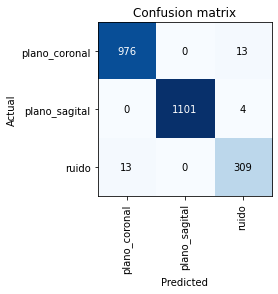

In [32]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

In [46]:
cleaner = ImageClassifierCleaner(learn)
cleaner

In [47]:
for idx in cleaner.delete(): cleaner.fns[idx].unlink()

In [6]:
learn = train(arch, epochs=5,
              item=Resize(200, method=ResizeMethod.Pad, pad_mode=PadMode.Zeros),
              batch=aug_transforms(size=(192,192), min_scale=0.75))

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.686670,0.567698,0.698853,0.301147,12:19


epoch,train_loss,valid_loss,accuracy,error_rate,time


KeyboardInterrupt: 

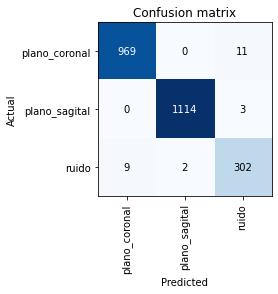

In [50]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

Ahora si hemos mejorado considerablemente nuestro resultados hasta llegar a 0.010 de error rate

In [51]:
tta_preds,targs = learn.tta(dl=learn.dls.valid)

In [52]:
error_rate(tta_preds, targs)

TensorBase(0.0087)

In [53]:
accuracy(tta_preds, targs)

TensorBase(0.9913)

In [69]:
dls.vocab

['plano_coronal', 'plano_sagital', 'ruido']

parece que la codificacion es tal que asi :  plane_coronal 0, plane_sagital 1,ruido 2

Como curiosidad con dls.vocab te sale el orden alfabetico de las categorias del dataloader que coincidira con las asignaciones de nuestro modelo de aprendizaje.
Es decir 0,1,2

In [55]:
learn.export()